## **Predicting Insurance Costs**

In this project, we aim to predict insurance costs based on the [Medical Cost Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from kaggle. 
The dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

Below is the data dictionary:
- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

By analysing these characheristics, our goal is to develop a predictive model that can assist in estimating insurance costs for individuals. This valuable tool can help both insurers and policy holders make informed decisions regarding healthcare coverage. 

### Import Libraries

In [1]:
# import the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

### Load the Dataset

To get started, let's load the dataset in so that we can start examining it.

In [2]:
#load the dataset
insurance = pd.read_csv('insurance.csv')

#print the information on the dataset
insurance.info()

#examine the dataset
insurance.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Explore the Dataset

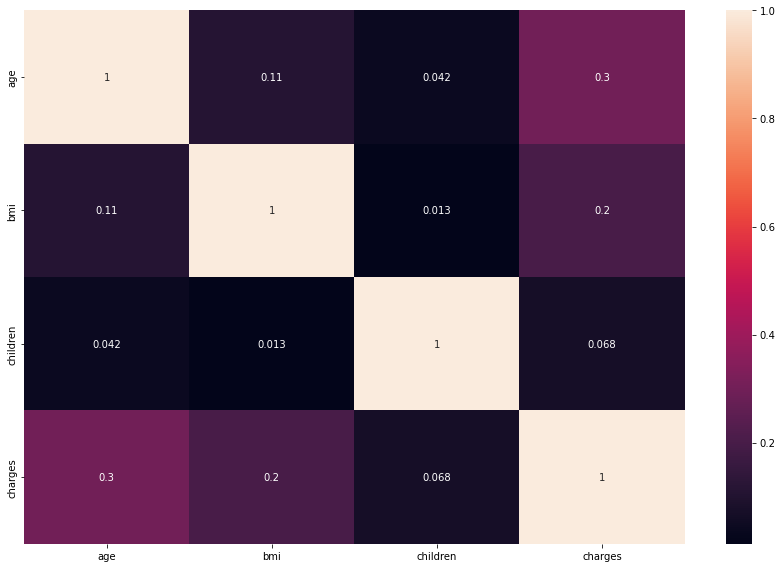

In [3]:
#examine the correlation between columns
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(insurance.corr(), annot=True, ax=ax)

plt.tight_layout()
plt.show()

The outcome(charges column) charges shows high correlation with the Age and bmi column. It will be a good choice for our predictors. None of the predictors show high correlation with each other. 

Next, we will group the outcome by the catgorical columns (smoking habits, segions and sex).

In [4]:
#examine the categorical smoking column
smokes = insurance.groupby(by='smoker')['charges'].mean()
smokes

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

Text(0.5, 0.98, '')

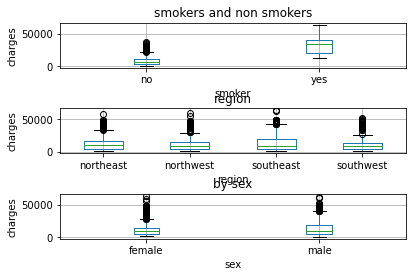

In [5]:
#  plot a boxplot for the categorical column
fig, ax = plt.subplots(3)
plt.figsize=(10,10)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.9)

insurance.boxplot(column=['charges'], by='smoker', ax=ax[0])
ax[0].set_title('smokers and non smokers')
ax[0].set_ylabel('charges')
fig.suptitle('')

insurance.boxplot(column=['charges'], by='region', ax=ax[1])
ax[1].set_title('region')
ax[1].set_ylabel('charges')
fig.suptitle('')

insurance.boxplot(column=['charges'], by='sex', ax=ax[2])
ax[2].set_title('by sex')
ax[2].set_ylabel('charges')
fig.suptitle('')

The graph above hsows that the smoker column is one of the predictors.

Next, we are going to modify the smoker column and examine the distribution of the charges column.

In [6]:
#replace yes with 1 and no with 0
insurance['smoker'] = insurance['smoker'].replace(['yes','no'],[1,0])
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


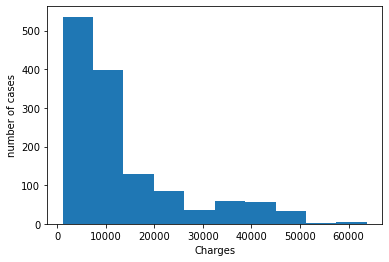

In [7]:
#plot a histogram for the charges
plt.hist(insurance['charges'])
plt.xlabel('Charges')
plt.ylabel('number of cases')
plt.show()

The graph shows that most of the charges are less than $20000 and expensive charges are less likely to occour.

We will now transform the outcome (log transformation) and examine the distribution.

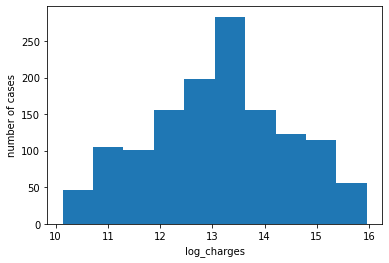

In [8]:
#plot the histogram of the log transformed outcome
insurance['log_charges'] = np.log2(insurance['charges']) 
plt.hist(insurance['log_charges'])
plt.xlabel('log_charges')
plt.ylabel('number of cases')
plt.show()

In [9]:
insurance.describe()

,age,bmi,children,smoker,charges,log_charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265,13.126590
std,14.049960,6.098187,1.205493,0.403694,12110.011237,1.326597
min,18.000000,15.960000,0.000000,0.000000,1121.873900,10.131695
25%,27.000000,26.296250,0.000000,0.000000,4740.287150,12.210758
50%,39.000000,30.400000,1.000000,0.000000,9382.033000,13.195685
75%,51.000000,34.693750,2.000000,0.000000,16639.912515,14.022358
max,64.000000,53.130000,5.000000,1.000000,63770.428010,15.960600


The histogram shows that the charges log is centered and less likely to produce biased errors. The basic statistics shows that the charges log is distribued more uniformly than the charges itself.

The predictors we will be working with going further is the 'age', 'bmi' and 'smoker' predictor because it shows high correlation with the outcome and also a significant change in the outcome.

### Divide the Data
Before we can build the model, we need to divide the insurance dataset into two portions:
1. A training set that will be used to estimate the regression coefficients
2. A test set that will be used to assess the predictive ability of the model

In [10]:
#split the dataset using the train_test_split function
X = insurance[['age','bmi','smoker']]
y = insurance["log_charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 730)

### Build the Model

Now that we've divided up the data into both a training and test set, we're ready to build our predictive linear model.

In [11]:
#build the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [12]:
#calculate the coefficient of determination
predictions = model.predict(X_train)
R2 = r2_score(y_train,predictions)
R2

0.7513666641041514

In [13]:
#Calculate the mean squared error (MSE) based on the training set.
train_mse = mean_squared_error(y_train, predictions)
train_mse

0.4370348389965148

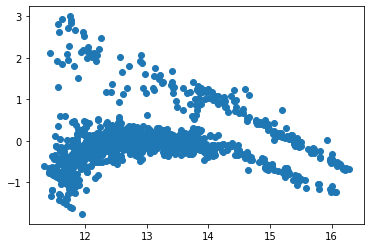

In [14]:
#plot a scatter to examine the variance of the residual
residuals = y_train - predictions

plt.scatter(predictions, residuals)
plt.show()

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

### Model Interpretation

In [15]:
slope = model.coef_
slope

array([0.05144329, 0.01640968, 2.22821728])

- A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 4% increase in the charges on the regular scale.
- A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.6% increase in the charges on the regular scale.
- A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.

Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

### Final Model Evaluation

In [16]:
#produce the fitted value on the test data
test_predictions = model.predict(X_test)

#calculate the mse on the testdata
train_mse = mean_squared_error(y_test, test_predictions)
train_mse

0.49834901277492666

In [17]:
# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_predictions))

1.6460014987166822

### Conclusion

The test MSE was about 0.437, while the training MSE was about 0.498.
In this case, the alignment between the two errors indicates that we can reasonably deduce that the model is not exhibiting overfitting. The residuals, on the other hand, indicate that the model tends to forecast considerably lower expenses for individuals who have, in reality, incurred significantly higher charges. Consequently, the model encounters difficulty when dealing with these elevated costs. To sum it up, the model's overall predictions lean towards being overly cautious or conservative.

Improving the model could be achieved by introducing more sophisticated elements into the regression, such as interaction terms or quadratic variables.